<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Mise-en-place-de-l'environnement" data-toc-modified-id="Mise-en-place-de-l'environnement-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Mise en place de l'environnement</a></span><ul class="toc-item"><li><span><a href="#Test-de-l'Environnement" data-toc-modified-id="Test-de-l'Environnement-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Test de l'Environnement</a></span></li></ul></li><li><span><a href="#Implémentation-de-l'Algorithme-Deep-Deterministic-Policy-Gradient-(DDPG)" data-toc-modified-id="Implémentation-de-l'Algorithme-Deep-Deterministic-Policy-Gradient-(DDPG)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Implémentation de l'Algorithme Deep Deterministic Policy Gradient (DDPG)</a></span><ul class="toc-item"><li><span><a href="#Création-de-l'Acteur" data-toc-modified-id="Création-de-l'Acteur-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Création de l'Acteur</a></span></li><li><span><a href="#Création-du-Critique" data-toc-modified-id="Création-du-Critique-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Création du Critique</a></span></li><li><span><a href="#Création-du-Générateur-de-Bruit" data-toc-modified-id="Création-du-Générateur-de-Bruit-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Création du Générateur de Bruit</a></span></li><li><span><a href="#Gestion-de-l'Experience-Replay" data-toc-modified-id="Gestion-de-l'Experience-Replay-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Gestion de l'Experience Replay</a></span></li><li><span><a href="#Mise-à-jour-des-réseaux-cibles" data-toc-modified-id="Mise-à-jour-des-réseaux-cibles-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Mise à jour des réseaux cibles</a></span></li><li><span><a href="#Apprentissage" data-toc-modified-id="Apprentissage-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Apprentissage</a></span></li><li><span><a href="#Diagnostique" data-toc-modified-id="Diagnostique-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Diagnostique</a></span></li><li><span><a href="#Réglage-des-paramètres-d'apprentissage" data-toc-modified-id="Réglage-des-paramètres-d'apprentissage-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Réglage des paramètres d'apprentissage</a></span></li></ul></li></ul></div>

Les modèles (physiques ou corrélatifs) des pneumatiques jouent un rôle essentiel dans la mise au points de scénarios de conception ainsi que dans l'évaluation des performances des nouvelles gammes ou de gammes existantes. Ainsi, le modèle de rigidité de dérive vu dans le TP portant sur l'Optimisation Bayesienne, peut être exploité à travers des chaines de simulation pour juger de la qualité de pneumatiques en terme de critère de comportement, d'adhérence, d'endurance ou encore de temps au tour. C'est à cette performance que nous allons nous intéresser ici.

Plus précisément, l'exercice consiste à mettre en place un environnement de simulation basé sur de l'apprentissage par renforcement qui a pour objectif de trouver les controles optimaux à appliquer à un véhicule pour que ce dernier puisse parcourir un circuit circulaire avec la vitesse la plus élevée possible.

## Mise en place de l'environnement

En l'occurence, les états que l'on va considérer pour notre environnement sont:
- $x$: position du véhicule selon la direction $\vec{X}$
- $y$: position du véhicule selon la direction $\vec{Y}$
- $\psi$: l'angle de lacet du véhicule
- $\dot{x}$: vitesse du véhicule selon la direction $\vec{X}$
- $\dot{y}$: vitesse du véhicule selon la direction $\vec{Y}$
- $\dot{\psi}$: vitesse de lacet du véhicule

Les actions qui seront utilisées sont:
- $v$: la vitesse
- $\alpha$: l'angle de braquage

L'environnement que l'on va exploiter s'appuie sur le package Gym de la société OpenAI (https://gym.openai.com/). Un tel environnement s'appuie sur l'utilisation d'objets héritant de la classe *gym.Env* et comportant les méthodes suivantes:
- **__init__**: constructeur définissant les expaces d'actions (*action_space*) et d'observations (*observation_space*)
- **reset**: méthode permettant de réinitialiser les états
- **step**: fonction qui prend en entrée les valeurs des actions et renvoie les nouveaux états de l'environnement, le reward ainsi qu'un booléen indiquant s'il est nécessaire de réinitialiser les états 
- **render**: méthode qui affiche l'état de l'environnement et différentes informations le concernant 

In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

from gym_gmmcar.envs.circle_env import CircleEnv

Notre objectif étant de rester sur le cirucuit tout en allant le plus vite possible, quel(-s) reward(-s) peut-on envisager? Implémenter l'un d'entre eux en complétant la méthode *get_reward* de la classe *OttEnv* ci-dessous:

In [2]:
class OttEnv(CircleEnv):
    """
    Environnement de simulation pour une voiture de course suivant une trajectoire circulaire aussi vite que possible
    """

    def __init__(
            self,
            target_velocity=1.0,
            radius=1.0,
            dt=0.035,
            model_type='BrushTireModel',
            robot_type='RCCar',
            mu_s=1.37,
            mu_k=1.96,
            eps=0.05
    ):

        super().__init__(
            target_velocity=target_velocity,
            radius=radius,
            dt=dt,
            model_type=model_type,
            robot_type=robot_type,
            mu_s=mu_s,
            mu_k=mu_k
        )

        self.eps = eps


    def get_reward(self, state, action):
        """
        Définition de la fonction de Reward
        """
        r = self.radius
        x, y, _, x_dot, y_dot, _ = state
        vitesse = np.sqrt(x_dot**2 + y_dot**2)
        distance = np.sqrt(x**2 + y**2) - r

        # Reward à définir
        
        distance_reward = abs(distance)
        vitesse_reward = vitesse
        reward = vitesse_reward - distance_reward
        
        
        info = {}
        info['dist'] = distance
        info['vel'] = vitesse
        return reward, info

### Test de l'Environnement

Tester l'environnement en considérant un épisode de 100 pas de temps et des actions aléatoires et/ou fixes. Pour ce faire, compléter le script ci-dessous en définissant les actions à appliquer à chaque pas.

4


C:\Users\perra\anaconda3\envs\Michelin\lib\site-packages\gym\spaces\box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


<IPython.core.display.Javascript object>


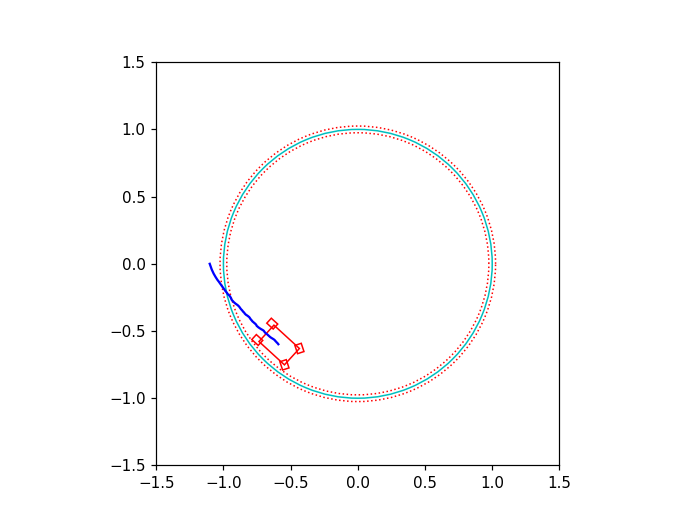

[ 0.10186263 -0.66105468 -1.31693604 -1.54751388]


In [3]:
env = OttEnv()
obs = env.reset()
print(env.observation_space.shape[0])
env.render()


episode = 1
for step in range(100):
    #action = np.array([1.0, 0.0])
    action = np.random.uniform(low=-1.0, high=1.0, size=(2,))
    # Mettre une valeur random sur les action, pour tester : OK
    new_state, reward, done, info = env.step(action)
    env.render()
    
print(obs)

Etant donné les caractéristiques du problème considéré, quel type de méthode devrait-on appliquer?

## Implémentation de l'Algorithme Deep Deterministic Policy Gradient (DDPG)

Pour tenter de trouver les commandes optimales à appliquer, nous allons ici utiliser une approche DDPG. Pour ce faire, la première étape à réaliser est d'implémenter cette méthode en s'appuyant sur le pseudo-code suivant vu en cours:
![DDPG.png](DDPG.png "Algorithme DDPG")

### Création de l'Acteur

Pour rappel, l'acteur a pour objectif d'estimer un politique $\mu(s_{t})$. Dans un premier temps, créer un acteur à partir d'une fonction ou d'une classe en définissant un modèle neuronal tensorflow ayant l'architecture suivante:
- une première couche cachée dense comportant 256 neurones et une fonction d'activation de type RELU
- une seconde couche cachée dense comportant 256 neurones et une fonction d'activation de type RELU
- une couche de sortie dense comportant un nombre de neurones égal au nombre d'actions et une fonction d'activation de type tanh

<ins>**Remarque:**</ins> Les sorties étant bornées entre -1 et 1, ne pas oublier de dénormaliser pour générer des valeurs d'actions conformes à l'espace des actions.
<ins>**Conseil:**</ins> Pour pouvoir tester différentes architectures par la suite, paramétrer les couches à l'aide d'une variable indiquant le nombre de neurones. 

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras import Input

In [5]:
# Définition de l'acteur 

def actor(nb_neurones,nb_action=2,dim_entry_etat=6):
    
    x0 = Input(shape=(dim_entry_etat,))
    x1 = tf.keras.layers.Dense(nb_neurones,activation='relu')(x0)
    x2 = tf.keras.layers.Dense(nb_neurones, activation='relu')(x1)

    ## si besoin de normalisation
    #x2_normalized = tf.keras.layers.BatchNormalization()(x2)
    
    #x3 = Dense(nb_action, activation='tanh')(x2_normalized)

    x3 = tf.keras.layers.Dense(nb_action, activation='tanh')(x2)
    
    actor = Model(inputs=x0, outputs=x3)
    
    return actor

In [6]:
# Test :
A=actor(256)

### Création du Critique

Pour rappel, le critique a pour objectif d'estimer la valeur $Q(s_{t},a_{t})$Dans un premier temps, créer un critique à partir d'une fonction ou d'une classe en définissant un modèle neuronal tensorflow de la manière suivante:
- Créer un réseau prenant en entrée les états avec:
  - une première couche cachée dense comportant 16 neurones et une fonction d'activation de type RELU
  - une seconde couche cachée dense comportant 32 neurones et une fonction d'activation de type RELU
- Créer un réseau prenant en entrée les actions avec une couche cachée dense comportant 32 neurones et une fonction d'activation de type RELU
- Concaténer les sorties des 2 réseaux précédents via la méthode "*Concatenate*"
- Créer un réseau prenant les entrées la concaténation des tenseurs précédents avec:
  - une première couche cachée dense comportant 256 neurones et une fonction d'activation de type RELU
  - une seconde couche cachée dense comportant 256 neurones et une fonction d'activation de type RELU
  - une couche de sortie dense comportant 1 neurone sans fonction d'activation 

<ins>**Conseil:**</ins> Pour pouvoir tester différentes architectures par la suite, paramétrer les couches à l'aide d'une variable indiquant le nombre de neurones. 

In [7]:
from tensorflow.keras.layers import concatenate

In [8]:
# Définition du critique


def critic(nb_neurones_couches, dim_entry_etat=6, dim_entry_action=2):
    
    # Premier réseau avec les états
    x0_1 = Input(shape=(dim_entry_etat,))
    x1_1 = tf.keras.layers.Dense(nb_neurones_couches[0], activation='relu')(x0_1)
    x2_1 = tf.keras.layers.Dense(nb_neurones_couches[1], activation='relu')(x1_1)
    
    # Deuxième réseau avec les actions
    x0_2 = Input(shape=(dim_entry_action,))
    x1_2 = tf.keras.layers.Dense(nb_neurones_couches[2], activation='relu')(x0_2)
    
    # Concaténation
    x0_3 = concatenate([x2_1, x1_2])
    
    # Troisième Réseau
    x1_3 = tf.keras.layers.Dense(nb_neurones_couches[3], activation='relu')(x0_3)
    x2_3 = tf.keras.layers.Dense(nb_neurones_couches[4], activation='relu')(x1_3)
    x3_3 = tf.keras.layers.Dense(1)(x2_3)
    
    critic = Model(inputs=[x0_1, x0_2], outputs=x3_3)
    
    return critic

In [9]:
nb_neurones=[16,32,32,256,256]

In [10]:
C=critic(nb_neurones)

### Création du Générateur de Bruit

Comme précisé en cours, l'approche DDPG génère les actions de manière déterministe, ce qui engendre mécaniquement une démarche purement basée sur de l'exploitation. Pour éviter d'être coincé dans un optimum local, il est nécessaire d'appliquer une stratégie d'exploration. En l'occurrence, cette exploration est gérée via l'ajout d'un bruit à l'action générée par l'acteur.
Ce bruit est généré via un processus stochastique de type ***Ornstein-Uhlenbeck*** défini par l'équation différentielle stochastique:

$dx_{t}=\theta(\nu-x_{t})dt+\sigma\sqrt{d_{t}}u$ avec $u\sim \mathcal{N}(0,1)$

Créer une fonction ou classe permettant de générer ce bruit avec $\theta=0.15$ et $d_{t}=1e-2$.

In [11]:
# Définition du génrateur de bruit

def bruit(sigma,v,xt,teta=0.15,dt=1e-2):
    
    u=np.random.rand(2)
    # 2 Car deux actions possibles 
     
    dx=teta*(v-xt)*dt+sigma*np.sqrt(dt)*u
    
    return dx

### Gestion de l'Experience Replay

Afin de ne pas oublier les expériences passées et réduire les corrélations entre expériences, un tirage aléatoire de $N$ tuples (état présent, action, reward, état suivant) stockés dans un buffer de taille $B$.
Créer une fonction ou classe permettant de:
- Initialiser un buffer de taille $B$ à 0
- Sauvegarder à chaque pas de temps un 4-uplet (état présent, action, reward, état suivant)
- Tirer aléatoirement $N$ tuples (état présent, action, reward, état suivant)

In [12]:
def initialisation_Replay(B):

    Buffer=[]
    for i in range(B):
        liste=[[0,0,0,0],[0,0],0,[0,0,0,0,0,0]]

        Buffer.append(liste)
    

    return Buffer
# Ou faire en Matrice a voir

def save_Replay(Buffer,present,action,reward,suivant,pas):

    liste=[present,action,reward,suivant]
    Buffer[pas]=liste
    
    return Buffer

def tirage_Replay(Buffer,N,B):

    nombre=[]
    Tuples=[]

    for i in range(N):

        alea=np.random.randint(0,B)
        nombre.append(alea)

    for j in range(len(nombre)):

        Tuples.append(Buffer[nombre[j]])

    return Tuples

In [13]:
#test : Initialisation
buffer=initialisation_Replay(10)
buffer

[[[0, 0, 0, 0], [0, 0], 0, [0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0], [0, 0], 0, [0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0], [0, 0], 0, [0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0], [0, 0], 0, [0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0], [0, 0], 0, [0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0], [0, 0], 0, [0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0], [0, 0], 0, [0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0], [0, 0], 0, [0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0], [0, 0], 0, [0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0], [0, 0], 0, [0, 0, 0, 0, 0, 0]]]

In [14]:
#test : Sauvegarde

buffer_save=save_Replay(buffer,[10,11,12,13,14,15],[5,2],12,[4,5,6,7,8,9],4)
buffer_save

[[[0, 0, 0, 0], [0, 0], 0, [0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0], [0, 0], 0, [0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0], [0, 0], 0, [0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0], [0, 0], 0, [0, 0, 0, 0, 0, 0]],
 [[10, 11, 12, 13, 14, 15], [5, 2], 12, [4, 5, 6, 7, 8, 9]],
 [[0, 0, 0, 0], [0, 0], 0, [0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0], [0, 0], 0, [0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0], [0, 0], 0, [0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0], [0, 0], 0, [0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0], [0, 0], 0, [0, 0, 0, 0, 0, 0]]]

In [15]:
#test : Tirage

T=tirage_Replay(buffer,2,10)
T

[[[0, 0, 0, 0], [0, 0], 0, [0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0], [0, 0], 0, [0, 0, 0, 0, 0, 0]]]

### Mise à jour des réseaux cibles

Comme présenté en cours, la gestion des cibles mouvantes se fait via la mise en place de réseaux cibles. En l'occurrence, deux réseaux cibles sont utilisés: l'un pour l'acteur et l'autre pour le critique.
Créer une fonction ou classe qui mette à jour les poids des réseaux cibles.

In [16]:
# Mise à jour des réseaux cibles

def Mise_a_jour_crit(tau, critic_model, target_critic_model):
    critic_weights = critic_model.get_weights()
    target_critic_weights = target_critic_model.get_weights()
    for i in range(len(critic_weights)):
        target_critic_weights[i] = tau * critic_weights[i] + (1 - tau) * target_critic_weights[i]
    target_critic_model.set_weights(target_critic_weights)

    return target_critic_model

def Mise_a_jour_acteur(tau, actor_model, target_actor_model):
    actor_weights = actor_model.get_weights()
    target_actor_weights = target_actor_model.get_weights()
    for i in range(len(actor_weights)):
        target_actor_weights[i] = tau * actor_weights[i] + (1 - tau) * target_actor_weights[i]
    target_actor_model.set_weights(target_actor_weights)

    return target_actor_model

### Apprentissage

Utiliser l'ensembles des fonctions/classes précédemment construites pour implémenter l'apprentissage présenté par le pseudo-code apparaissant plus haut avec les paramètres suivants:
- learning rate de l'acteur:0.002
- learning rate du critique: 0.001
- paramètre du générateur de bruit $\sigma$: 0.2
- paramètre du générateur de bruit $\nu$: 0
- nombre totale d'épisode $M$: 100
- facteur d'escompte $\gamma$: 0.99
- paramètre mise à jour des réseaux cible $\tau$: 0.005
- taille du buffer $B$: 1000
- taille $N$ des batchs: 100

Pour pouvoir mener un diagnosqtique de l'apprentissage, stocker les rewards cumulés à la fin de chaque épisode dans une liste.

In [17]:
from tensorflow.keras.optimizers import Adam

In [18]:
# Algorithme DDPG


def DDPG(learning_acteur=0.002,learning_crit=0.001,bruit_sigma=0.2, bruit_v=0.0, M=100, f_escompte=0.99, tau=0.005, 
          B=1000, N=100):
     

    nb_neurones = 256
    nb_neurones_couches = [16, 32, 32, 256, 256]

    # Initialisation des réseaux
    A = actor(nb_neurones)
    C = critic(nb_neurones_couches)
    A_target = actor(nb_neurones)
    
    # Ici le .set_weighths permet de changer les poids de A_prime et le A.get_weights() permet de prendre les poids de A 
    # Donc ça permet d'avoir deux réseau de neuronnes avec les même poids
    A_target.set_weights(A.get_weights())
    
    C_target = critic(nb_neurones_couches)
    C_prime.set_weights(C.get_weights())  

    # Initialisation des Optimizers
    A_optimizer = Adam(learning_rate=0.001)
    C_optimizer = Adam(learning_rate=0.001)
    

    # Initialisation du replay buffer
    Buffer = initialisation_Replay(B)

    # Initialisation de l'environnement
    env = OttEnv()

    episode_rewards = []

    # On prend quoi comme valeur de T
    T=3

    for episode in range(M):
        # Réinitialisation de l'environnement
        state = env.reset()
        env.render()
        total_reward = 0
        # Comment initialiser
        state1 = np.array([-1.28179312, -0.03076161, 3.81707614, 1.61656511, -0.1866938, -0.35831151])
        state = state1.reshape((1, 6))
        for t in range(T):
            #print(episode,t)
            #print(state)
            # Sélection de l'action avec le réseau d'acteur
            action = A.predict(state.reshape(1, -1))[0] + bruit(bruit_sigma, bruit_v, A.predict(state.reshape(1, -1)))
            # Exécution de l'action
            next_state, reward, done, _ = env.step(action[0])

            # Ajout de l'expérience au replay buffer
            if done :
                Buffer = save_Replay(Buffer, state, action, reward, next_state, episode)
               
            # Tirage d'un batch d'expériences du replay buffer
            batch = tirage_Replay(Buffer, N, B)
            
            # zip permet de prendre le batch directement et on le dispache en 
            # states, actions, rewards, next_states
            states, actions, rewards, next_states = zip(*batch)

            states=tf.convert_to_tensor(states)
            actions=tf.convert_to_tensor(actions)
            rewards=tf.convert_to_tensor(rewards)
            next_states=tf.convert_to_tensor(next_states)
            #print(rewards.shape)


            # Calcul des cibles pour l'entraînement du critique
            q_actions=A_target(next_states)
            q_target=tf.cast(rewards,tf.float64) + (tf.cast(tf.constant(1.0),tf.float64)-tf.cast(done,tf.float64))*f_escompte*tf.cast(C_target([next_states,q_actions]),tf.float64)

            # Entraînement du critique
            with tf.GradientTape() as tape:
                # Ici c'est state et non next_states
                current_q_value = C([next_states, actions],training=True)
                critic_loss = tf.reduce_mean(tf.math.pow(q_target-tf.cast(current_q_value,tf.float64),2))
                    
                #critic_loss = tf.reduce_mean(tf.square(targets - C([np.array(next_states), np.array(actions)])))
               
            grads_critic = tape.gradient(critic_loss, C.trainable_variables)
            C_optimizer.apply_gradients(zip(grads_critic, C.trainable_variables))

            # Entraînement de l'acteur
            with tf.GradientTape() as tape:
                # Ici c'est state et non next_states
                actions = A(next_states,training=True)
                current_q_value = C([next_states,actions],training=True)
                actor_loss = -tf.reduce_mean(current_q_value)

            grads_actor = tape.gradient(actor_loss, A.trainable_variables)
            A_optimizer.apply_gradients(zip(grads_actor, A.trainable_variables))

            # Mise à jour des réseaux cibles
            A_target=Mise_a_jour_acteur(tau,A,A_target)
            C_target=Mise_a_jour_acteur(tau,C,C_target)

            total_reward += reward
            state = next_state

            if done:
                break
        episode_rewards.append(total_reward)
        print(f"Épisode {episode + 1}/{M}, Reward cumulé: {total_reward}")

        
    return episode_rewards


<IPython.core.display.Javascript object>


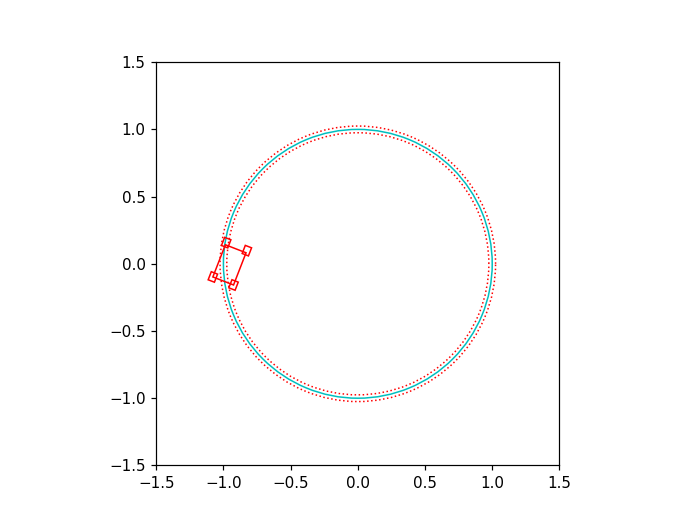

Épisode 1/100, Reward cumulé: 1.3770180716364662
Épisode 2/100, Reward cumulé: 0.69123747759524
Épisode 3/100, Reward cumulé: 0.6874304266809328
Épisode 4/100, Reward cumulé: 1.2794964780940563
Épisode 5/100, Reward cumulé: 0.9273483063988436
Épisode 6/100, Reward cumulé: 0.8230218325774687
Épisode 7/100, Reward cumulé: 1.2795440941298968
Épisode 8/100, Reward cumulé: 2.6508156476657803
Épisode 9/100, Reward cumulé: 2.066632315893846
Épisode 10/100, Reward cumulé: 0.5008638529790159
Épisode 11/100, Reward cumulé: 0.6758099413907347
Épisode 12/100, Reward cumulé: 1.381522627281055
Épisode 13/100, Reward cumulé: 2.6120161701718656
Épisode 14/100, Reward cumulé: 3.556638596667643
Épisode 15/100, Reward cumulé: 1.657984542259885
Épisode 16/100, Reward cumulé: 0.5273940501515353
Épisode 17/100, Reward cumulé: 3.094733241651051
Épisode 18/100, Reward cumulé: 2.7906573655418154
Épisode 19/100, Reward cumulé: 0.5053802826068969
Épisode 20/100, Reward cumulé: 3.7887884280228037
Épisode 21/100, 

KeyboardInterrupt: 

In [19]:
rewards=DDPG()

### Diagnostique

Afficher l'évolution de la moyenne des rewards cumulés calculée tous les 20 épisodes.

In [23]:
# Affichage de la moyenne des rewards cumulés
mean_reward=[]
for episode in range(100):
    if episode % 20 ==0:
        mean_reward.append(sum(rewards[episode-20:]) / 20.0)


In [24]:
mean_reward

[1.3387278801943252,
 7.116534701193851,
 5.75708157493672,
 4.388703887071175,
 2.881557225721894]

In [30]:
x

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [32]:
x=np.linspace(0,100,5)
plt.plot(x,mean_reward)
plt.savefig("resultasts3.png")

<IPython.core.display.Javascript object>

### Réglage des paramètres d'apprentissage

Essayer différents paramètres utilisés lors de l'apprentissage ainsi que différentes architecture de réseaux de neurones. Comment pourrait-on automatiser une recherche intelligente de cesdivers paramètres?

In [ ]:
# Tests et évaluation avec différentes configurations

